In [1]:
import vaft
import omas
vaft.database.is_connect()

True

In [2]:
shotnumbers=vaft.database.exist_file('public')
ods=vaft.database.load(39916,'public')

Total number of shots: 2128
Shot numbers: [114, 12345, 38000, 38028, 38029, 38030, 38032, 38036, 38039, 38041, 38042, 38045, 38052, 38055, 38057, 38058, 38059, 38060, 38062, 38063, 38064, 38067, 38184, 38187, 38188, 38189, 38190, 38191, 38192, 38193, 38195, 38196, 38197, 38198, 38199, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38236, 38245, 38247, 38248, 38249, 38251, 38252, 38253, 38254, 38255, 38256, 38257, 38258, 38266, 38267, 38269, 38309, 38310, 38311, 38313, 38315, 38316, 38317, 38318, 38319, 38320, 38321, 38322, 38323, 38324, 38349, 38350, 38352, 38353, 38355, 38356, 38357, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38371, 38372, 38373, 38374, 38379, 38380, 38386, 38387, 38388, 38389, 38390, 38391, 38393, 38396, 38397, 38410, 38411, 38413, 38414, 38415, 38429, 38430, 38431, 38432, 38434, 38436, 38437, 38438, 38439, 38440, 38441, 38442, 38443, 38444, 38445, 38446, 38447, 38449, 38450, 38451, 38572, 38573, 38574, 38575, 38580, 38629, 38631, 38632, 38636, 38670, 38671, 

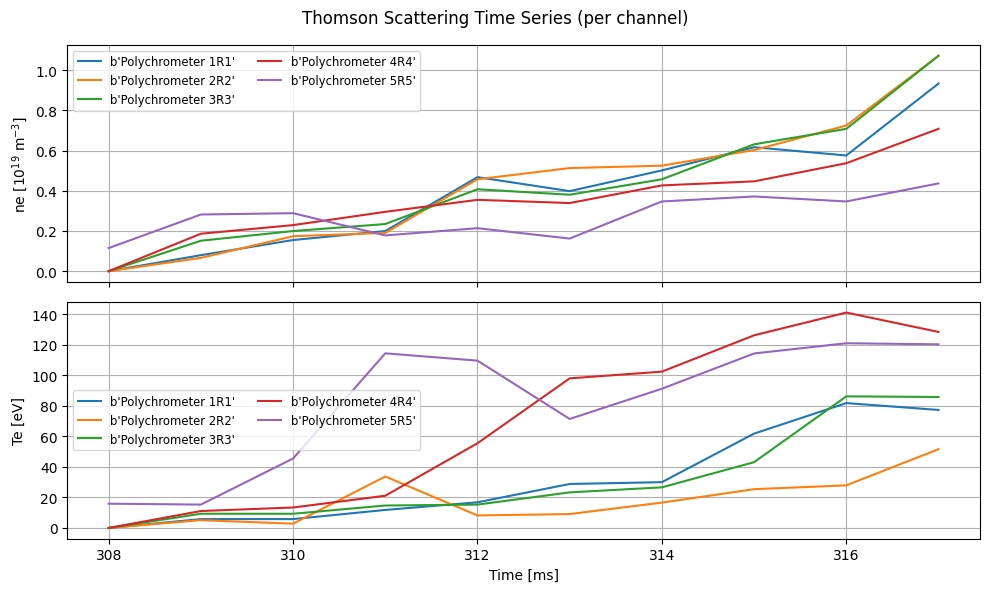

In [3]:
from vaft.plot import profile
profile.plot_thomson_time_series(ods)

In [4]:
profile.plot_electron_profile_with_thomson(ods)

No core_profiles data found.
